# Solar PV System Simulation

### import

In [32]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

### Set up configuration of the PV system.

In [33]:
n_module_per_string = 25  # Number of modules per string
n_string_per_combiner = 20  # Number of strings per combiner box
n_combiner_mppt = 6  # Number of combiner boxes per MPPT input
n_inverter_mppt = 2  # Number of MPPT inputs per inverter

### Define physical constants.

In [34]:
q = 1.60217663e-19  # Charge of an electron (Coulombs) - Electron charge (C)
k = 1.380649e-23  # Boltzmann constant (J/K)
T = 298  # Nominal cell temperature (K), equivalent to 25C
v_thermal = k * T / q  # Thermal voltage/potential (Volts)

print('Thermal voltage(V) = ', v_thermal)

Thermal voltage(V) =  0.025679653185304546


### Define solar panel module characteristics.

In [35]:
irrad = 1100  # Irradiance (W/m^2)
irrad_stc = 1000  # STC irradiance (W/m^2)
v_oc_const = -0.0025  # Temperature coefficient of Voc (Volts per degree Celsius)
i_sc_const = 0.00046  # Temperature coefficient of Isc (Amps per degree Celsius)
temp_env = 25  # Environment temperature (Celsius)

### STC values of the module.

In [36]:
p_max = 565  # Power at STC (Watts)
v_mp = 41.77  # Voltage at maximum power point at STC (Volts)
i_mp = 13.29  # Current at maximum power point at STC (Amps)
v_oc = 59.46 * (1 + v_oc_const * (temp_env - 25))  # Open-circuit voltage adjusted for temperature (Volts)
i_sc = 13.60 * (1 + i_sc_const * (temp_env - 25))  # Short-circuit current adjusted for temperature (Amps)

print('Open-circuit voltage(V) = ', v_oc)
print('Short-circuit current(A) = ', i_sc)

Open-circuit voltage(V) =  59.46
Short-circuit current(A) =  13.6


### Initialize variables for the iterative process.

In [37]:
i0 = 10  # Initial guess for the saturation current (Amps)
n = 80  # Initial guess for the ideality factor

### Iteratively solve for saturation current and ideality factor at STC.

In [38]:
for num in range(100):
    i0 = (i_sc - i_mp) / (math.exp(v_mp / (n * v_thermal)) - 1)
    n = (v_oc / v_thermal) / (math.log(i_sc + i0) - math.log(i0))
    
print('Saturation Current(A) = ', i0)
print('Ideality factor, n = ', n)

Saturation Current(A) =  4.11158070283099e-05
Ideality factor, n =  182.18719674647417


### Calculate Isc and Voc for the module under actual conditions.

In [39]:
i_sc_adj = i_sc * irrad / irrad_stc  # Adjust short-circuit current for irradiance
v_oc_adj = n * v_thermal * (math.log(i_sc_adj + i0) - math.log(i0))  # Adjust open-circuit voltage for irradiance

print('Adjusted I_sc & V_oc for the module under actual conditions:', i_sc_adj, '(A) &', v_oc_adj, '(V)')

Adjusted I_sc & V_oc for the module under actual conditions: 14.96 (A) & 59.90590777422437 (V)


### Generate the I-V and P-V curve data for the module.

In [40]:
step = 0.5  # Voltage step for the I-V curve
end = v_oc_adj + step  # End of the voltage range for the I-V curve
v_adj = np.arange(0, end, step)  # Voltage array for the I-V curve
i_adj = i_sc_adj - i0 * (np.exp(v_adj / (n * v_thermal)) - 1)  # Current array for the I-V curve
p_adj = v_adj * i_adj  # Power array for the P-V curve

### Plot module-level I-V and P-V curves.

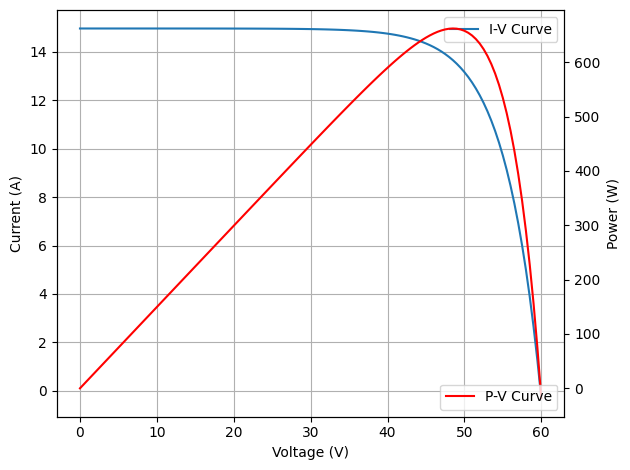

In [41]:
fig, x1 = plt.subplots()

# Configure the first y-axis (left) for current.
x1.set_xlabel("Voltage (V)")
x1.set_ylabel("Current (A)")
x1.plot(v_adj, i_adj, label="I-V Curve")

# Configure the second y-axis (right) for power.
x2 = x1.twinx()
x2.set_ylabel("Power (W)")
x2.plot(v_adj, p_adj, color="red", label="P-V Curve")

# Add grid and legend.
x1.grid(True)
x1.legend(loc='upper right')
x2.legend(loc='lower right')
fig.tight_layout()
plt.show()

# Scale module-level I-V and P-V curves to the system level.
v_inv = v_adj * n_module_per_string  # System voltage array
i_inv = i_adj * n_string_per_combiner * n_combiner_mppt * n_inverter_mppt  # System current array
p_inv = v_inv * i_inv  # System power array

plt.show()

### Plot system-level P-V curve with the operating range shaded.

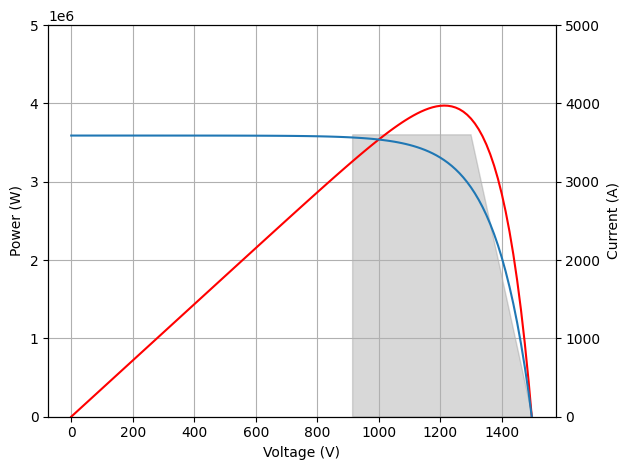

In [42]:
fig, x1 = plt.subplots()

# Configure the primary y-axis (left) for power.
x1.set_xlabel("Voltage (V)")
x1.set_ylabel("Power (W)")
x1.plot(v_inv, p_inv, color="red")

# Define the operating range polygon for shading. Use SG3600U as an example in NA market
inverter_op_range = np.array([[915, 0], [915, 3600000], [1300, 3600000], [1500, 0]])
# Add the shaded operating range to the plot.
x1.add_patch(mpatches.Polygon(inverter_op_range, closed=True, color='grey', alpha=0.3))

# Configure the secondary y-axis (right) for current.
x2 = x1.twinx()
x2.set_ylabel("Current (A)")
x2.plot(v_inv, i_inv)

# Set the plot limits to match the original graph.
x1.set_ylim([0, 5e6])
x2.set_ylim([0, 5000])

# Add grid and layout adjustments.
x1.grid(True)
fig.tight_layout()
plt.show()